# Contents:
- [1. Import Libraries & Data](#import-libraries)
- [2. Data Preprocessing](#data-preprocessing)
- [3. Models Experiments](#models)
    - [3.1 All Features](#All-Features)
    - [3.2 Feature-Selection](#Feature-Selection)
    - [3.3 Feature Selection using PCA](#Feature-Selection-PCA)
- [4. ANN](#ann)

<a id="import-libraries"></a>
# 1. Import Libraries & Data

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tensorflow as tf
import pickle
import random
np.random.seed(1)

#warnings.filterwarnings('ignore')

# preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# models 
from sklearn.linear_model import LinearRegression
from sklearn. linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import BayesianRidge
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from lightgbm import LGBMRegressor
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

# evaluation
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

In [28]:
data = pd.read_csv('../../data/final/clean_trial4.csv')

In [29]:
data.head(2)

,logkpl,Compound,SMILES,Texpi,ALogp2,nAcid,nAromBond,ATSc2,ATSc3,ATSc4,...,nRings9,TopoPSA,VAdjMat,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,XLogP,Zagreb
0,-3.55,Urea,C(=O)(N)N,312,1.085972,0,0,-0.116019,0.023614,0.0,...,0,69.11,2.584963,1.683013,6.732051,2.244017,4.488034,9.0,-1.686,12.0
1,-3.69,Urea,C(=O)(N)N,312,1.085972,0,0,-0.116019,0.023614,0.0,...,0,69.11,2.584963,1.683013,6.732051,2.244017,4.488034,9.0,-1.686,12.0


In [30]:
smiles_df = data[['SMILES', 'Compound']]
smiles_df.head(2)

,SMILES,Compound
0,C(=O)(N)N,Urea
1,C(=O)(N)N,Urea


In [31]:
data.shape

(417, 149)

In [32]:
data[data.duplicated()]

,logkpl,Compound,SMILES,Texpi,ALogp2,nAcid,nAromBond,ATSc2,ATSc3,ATSc4,...,nRings9,TopoPSA,VAdjMat,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,XLogP,Zagreb


In [33]:
# no missing values
data.isna().sum().sum()

0

<a id="data-preprocessing"></a>
# 2. Data Preprocessing

In [34]:
model_data = data.drop(["SMILES", 'Compound'], axis=1)

In [35]:
X = model_data.drop(["logkpl"], axis=1)
y = model_data['logkpl']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.15)

print("Shape of X_train: {} \t Shape of y_train: {}".format(X_train.shape, y_train.shape))
print("Shape of X_test: {} \t Shape of y_test: {}".format(X_test.shape, y_test.shape))

Shape of X_train: (354, 146) 	 Shape of y_train: (354,)
Shape of X_test: (63, 146) 	 Shape of y_test: (63,)


In [36]:
with open('../../models/scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

<a id="models"></a>
# 3. Models Experiments

In [43]:
def plot_feature_importance(model, cols, model_name, slice=20):
    importances = model.feature_importances_
    feature_names = cols#X.columns#selected_features_X.columns #

    # Create a pandas DataFrame with the feature importances
    df = pd.DataFrame({"feature": feature_names, "importance": importances})

    # Sort the DataFrame by importance score
    df = df.sort_values("importance", ascending=False).reset_index(drop=True)
    # df[:slice].to_excel("../../results/Feature Importance/{}_feature_importance.xlsx".format(model_name), index=False)

    # Create a bar plot using Seaborn
    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid")
    sns.barplot(x="importance", y="feature", data=df[:slice])
    plt.title("Top 20 Feature Importances {}".format(model_name))
    plt.ylabel("Feature Name")
    plt.xlabel("Importance")
    plt.show()

<a id="All-Features"></a>
### 3.1 All Features

In [44]:
def ANN_model(X_train, X_test, y_train, y_test):
    
    model = tf.keras.Sequential([

    tf.keras.layers.Dense(256, input_shape=[X_train.shape[1]]),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8),
    tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss="mean_absolute_error")

    history = model.fit(X_train, y_train, epochs=2500, validation_data=(X_test, y_test), verbose=2)

    plt.title('Learning Curves')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

    predictions = model.predict(X_test)

    # MAE, MSE, RMSE
    print("MAE: {}".format(mean_absolute_error(y_test, predictions)))
    print("MSE: {}".format(mean_squared_error(y_test, predictions)))
    print("RMSE: {}".format(mean_squared_error(y_test, predictions, squared=False)))
    print("MAPE: {}".format(mean_absolute_percentage_error(y_test, predictions)))
    print("R2: {}".format(r2_score(y_test, predictions)))

    final_result = pd.DataFrame({"predicted": model.predict(X_test).reshape(X_test.shape[0],), 
              "actual": y_test})
    
    # saving the model

# serialize model to JSON
    model_json = model.to_json()
    # with open("../../models/ANN_model.json", "w") as json_file:
    #     json_file.write(model_json)
    # # serialize weights to HDF5
    # model.save_weights("../../models/ANN_model.h5")
    print("Saved model to disk")

    # load json and create model
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# loaded_model.predict(X_test[0].reshape((1, 512, 512, 1))).argmax(axis=1)
# print("Loaded model from disk")
    
    return final_result.reset_index(drop=True)

In [45]:
def evaluate_model(model_df, i, model_name, model, X_train, y_train, X_test, y_test):
    """
    this function is for regression takes the model with the data and calculate
    the scores, with cross validation techniques, in addition to MAE, MSE, RMSE, MAPE
    R Squared and Adjusted R Squared

    :param model: model
    :param X_train, X_test, y_train, y_test: data that was used
    """

    # cross validation with 5 folds
    all_cv_5 = cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_absolute_error")
    #print("all CV 5: {}".format(all_cv_5))
    # print("Mean Cross-Validation score: {}".format(all_cv_5.mean()))

    # predictions from our model
    predictions = model.predict(X_test)


    # calculating R squared and Adjusted R squared
    r_sqre = r2_score(y_test, predictions)
    n = len(y_test)
    p = X_test.shape[1] # number of independant features

    Adj_r2 = 1 - ((1 - r_sqre) * (n - 1) / (n - 1 - p))
    
    test_mae = mean_absolute_error(y_test, predictions)

    test_mse = mean_squared_error(y_test, predictions)
    test_rmse = np.sqrt(mean_squared_error(y_test, predictions))

    
    # Plotting
    plt.figure(figsize=(12, 8))
    plt.scatter(y_test, predictions, color='blue', label='Predicted vs Actual')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Predicted vs Actual {}'.format(model_name))
    plt.legend()
    plt.show()
    #print("=" * 40)
    model_df.loc[i] = [model_name, all_cv_5.mean(),
                    test_mae, mean_absolute_percentage_error(y_test, predictions),
                   test_mse, test_rmse, r_sqre, Adj_r2]

    return model_df

In [46]:
def train_and_evalute(X_train, X_test, y_train, y_test, metric):
    # scaler = StandardScaler()
    # X_scaled = scaler.fit_transform(X)

    # X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

    # print("Shape of X_train: {} \t Shape of y_train: {}".format(X_train.shape, y_train.shape))
    # print("Shape of X_test: {} \t Shape of y_test: {}".format(X_test.shape, y_test.shape))

    # Building pipelins of standard scaler and model for varios regressors.

    lr = LinearRegression()

    lasso = Lasso()

    dt = DecisionTreeRegressor()

    rf = RandomForestRegressor()

    xgb = XGBRegressor()

    gbr = GradientBoostingRegressor()

    eln = ElasticNet()

    br = BayesianRidge()

    cat = CatBoostRegressor(allow_writing_files=False, verbose=0, task_type="GPU")

    lgbm = LGBMRegressor()



    # List of all the pipelines
    pipelines = [lr, lasso, dt, rf, xgb, gbr,
                eln, br, cat, lgbm] # 

    # Dictionary of pipelines and model types for ease of reference
    ml_dict = {0: "LinearRegression", 1: "Lasso", 2: "DecisionTree", 3: "RandomForest", 4: "XGBRegressor", 5: "GradientBoostingRegressor",
                    6: "Elastic Net", 7:"BayesianRidge", 8: "CatBoostRegressor", 9: "LGBMRegressor"}
        #, 

    models_scores_df = pd.DataFrame(columns=["model", "Mean CV", "MAE",
                                            "MAPE", "MSE", "RMSE", "R_Squared", "Adjusted_R_Squared"])



    # Fit the pipelines and display the scores with Cross validation
    for i, pipe in enumerate(pipelines):
        # getting the name of our model
        model_name = ml_dict[i]
        print(model_name)
        
        # fitting our data
        pipe.fit(X_train, y_train)
        
        evaluate_model(models_scores_df, i, model_name, pipe, X_train, y_train, X_test, y_test)


    # selecting top 3 score based on metric
    filtered_models_scores_df =  models_scores_df.sort_values(metric).iloc[:3, :]

    results_df = pd.DataFrame({"actual": y_test})
    selected_compounds = smiles_df.iloc[results_df.index]
    results_df['Compound'] = selected_compounds['Compound']
    results_df['SMILES'] = selected_compounds['SMILES']

    results_df = results_df.reset_index(drop=True)
    li = []

    for i in filtered_models_scores_df.index:
        predictions = pipelines[i].predict(X_test)
        
        predictions_df = pd.DataFrame({"predictions_{}".format(ml_dict[i]): predictions})
        li.append(predictions_df)
        plot_feature_importance(pipelines[i],  X.columns, ml_dict[i])

        # save the model to disk
        # filename = '../../models/{}_model.sav'.format(ml_dict[i])
        # pickle.dump(pipelines[i], open(filename, 'wb'))

    li_df = pd.concat(li, axis=1)

    return models_scores_df, pd.concat([results_df, li_df], axis=1)
# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
# print(result)

LinearRegression


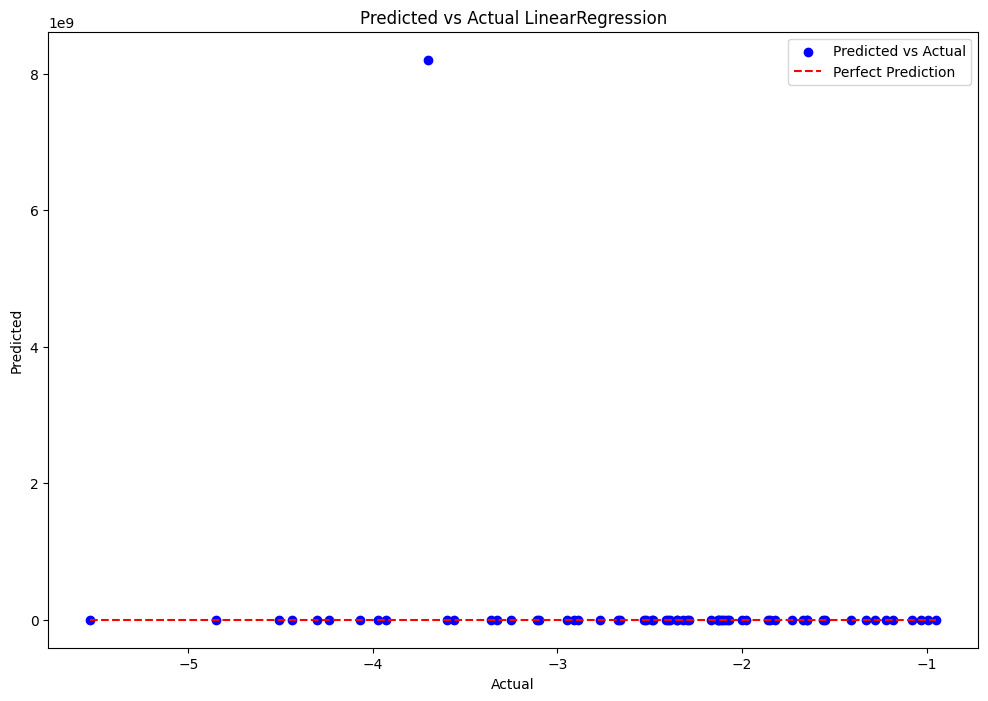

Lasso


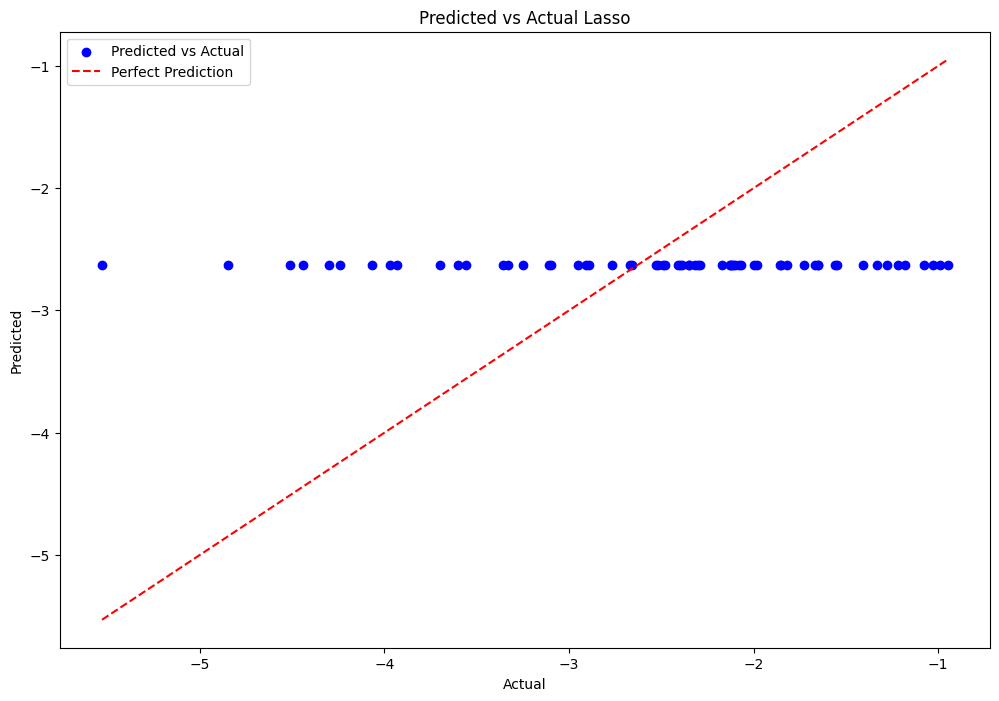

DecisionTree


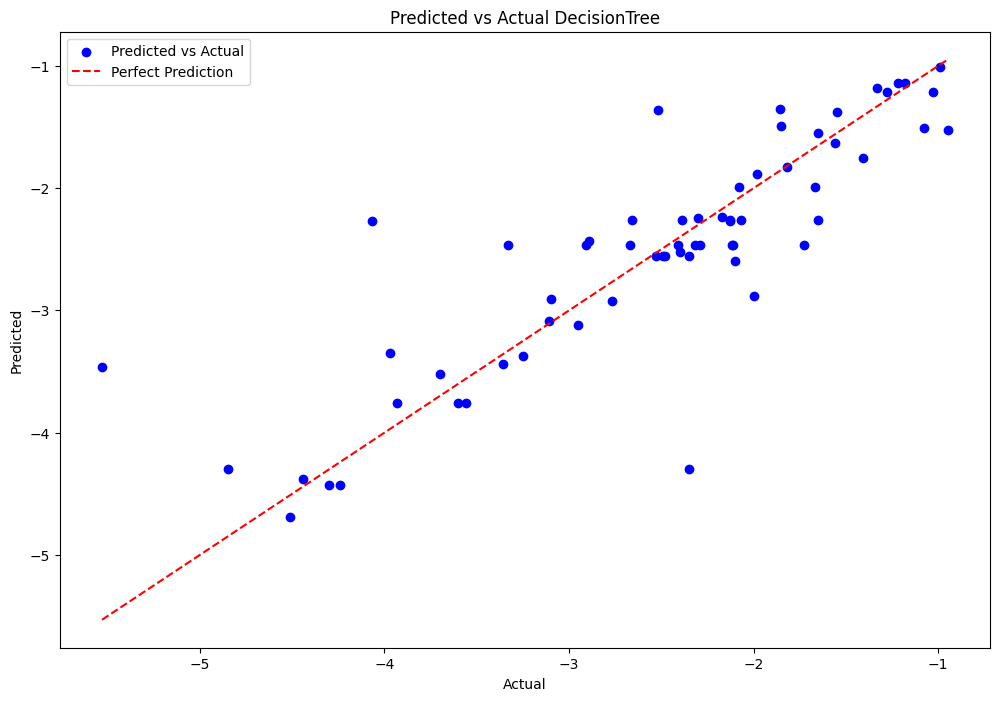

RandomForest


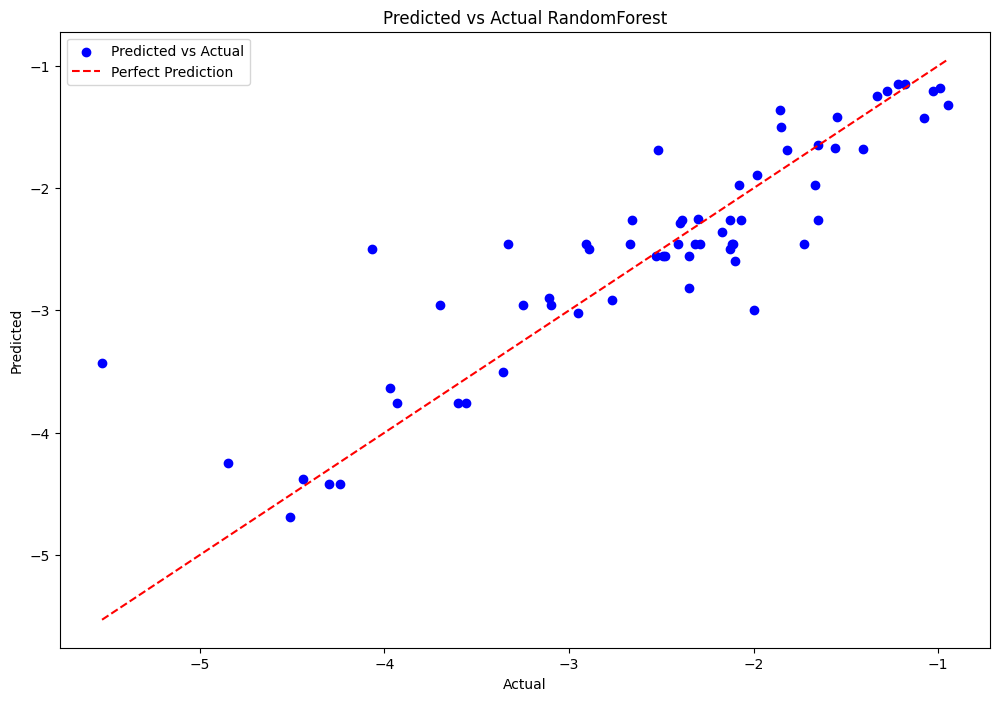

XGBRegressor


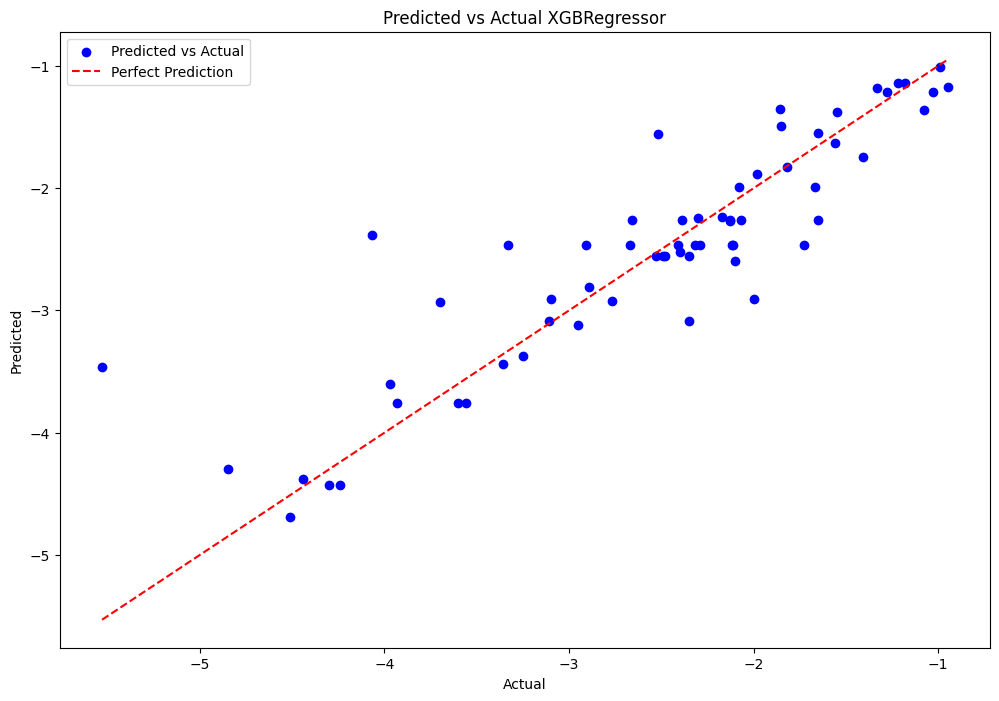

GradientBoostingRegressor


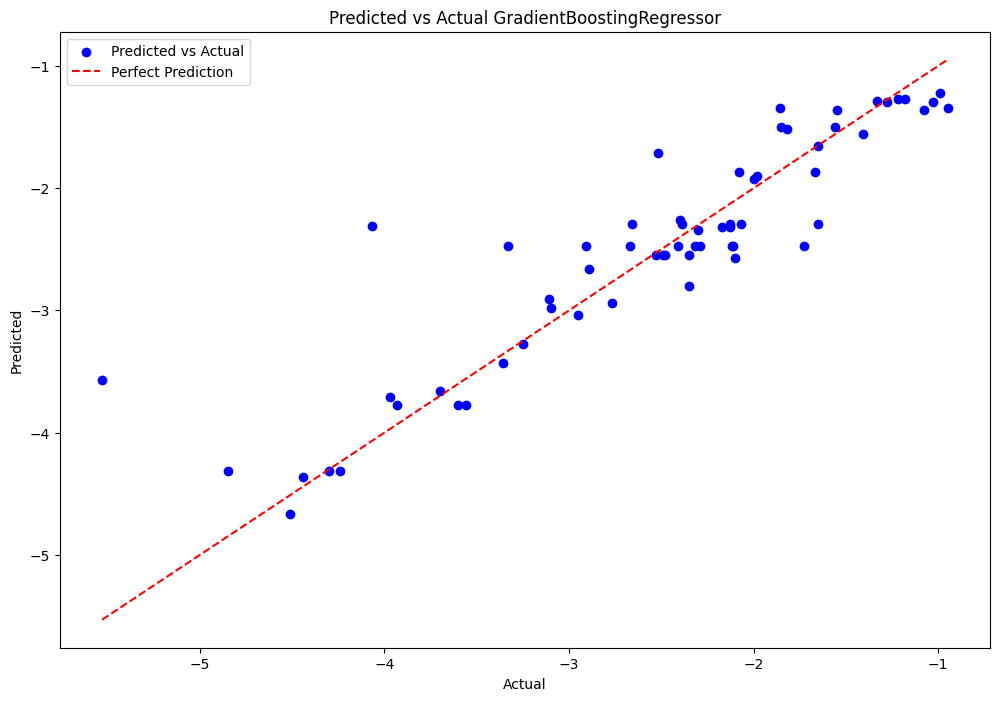

Elastic Net


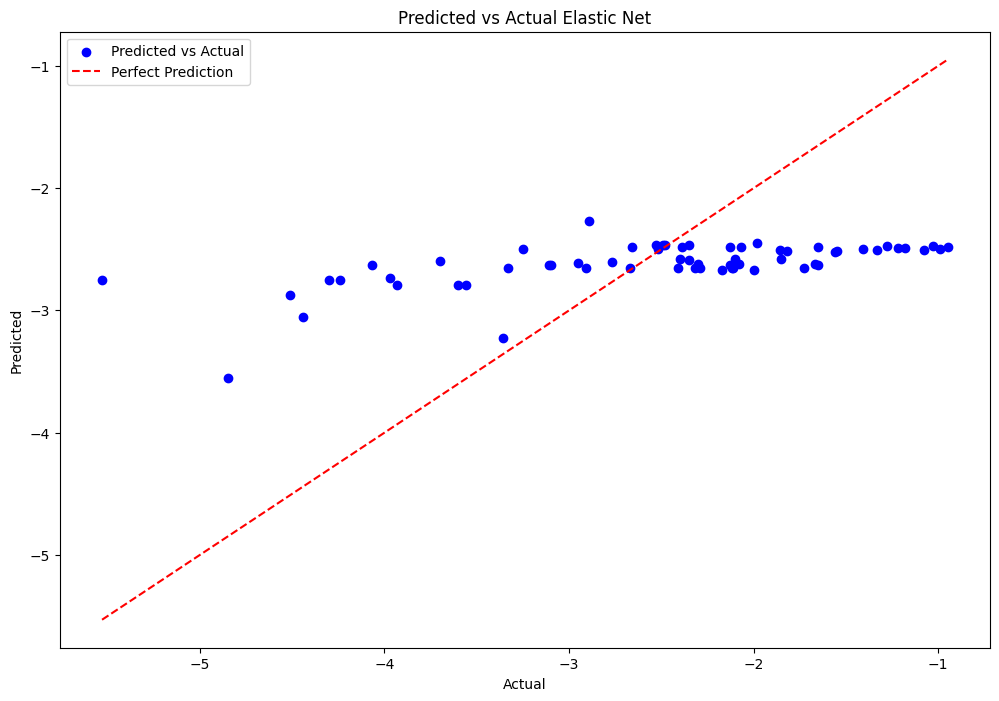

BayesianRidge


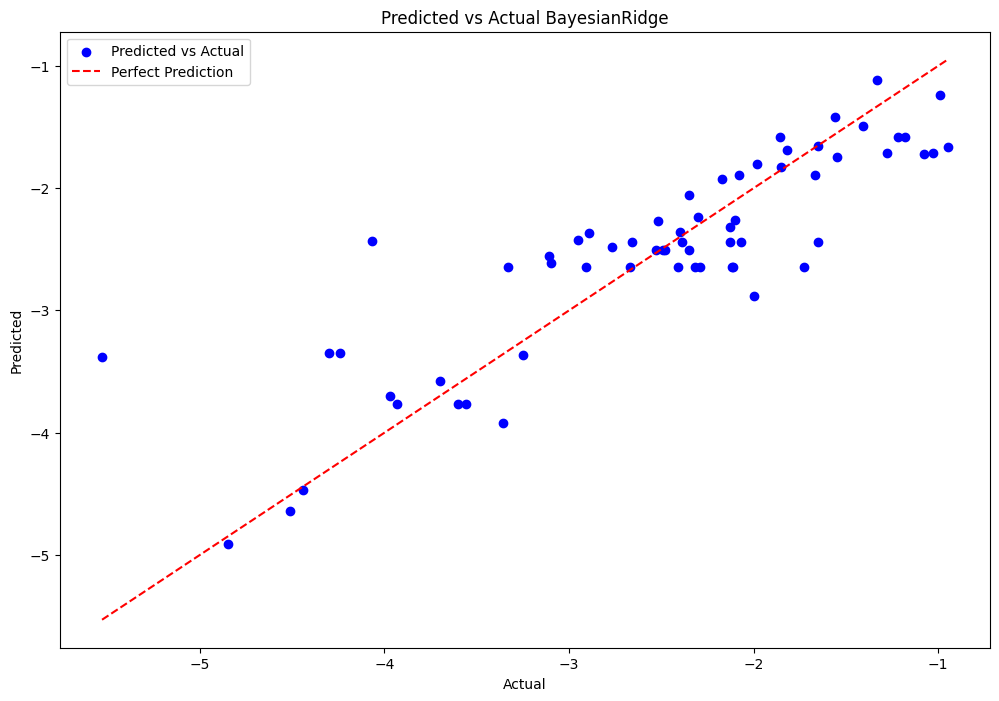

CatBoostRegressor


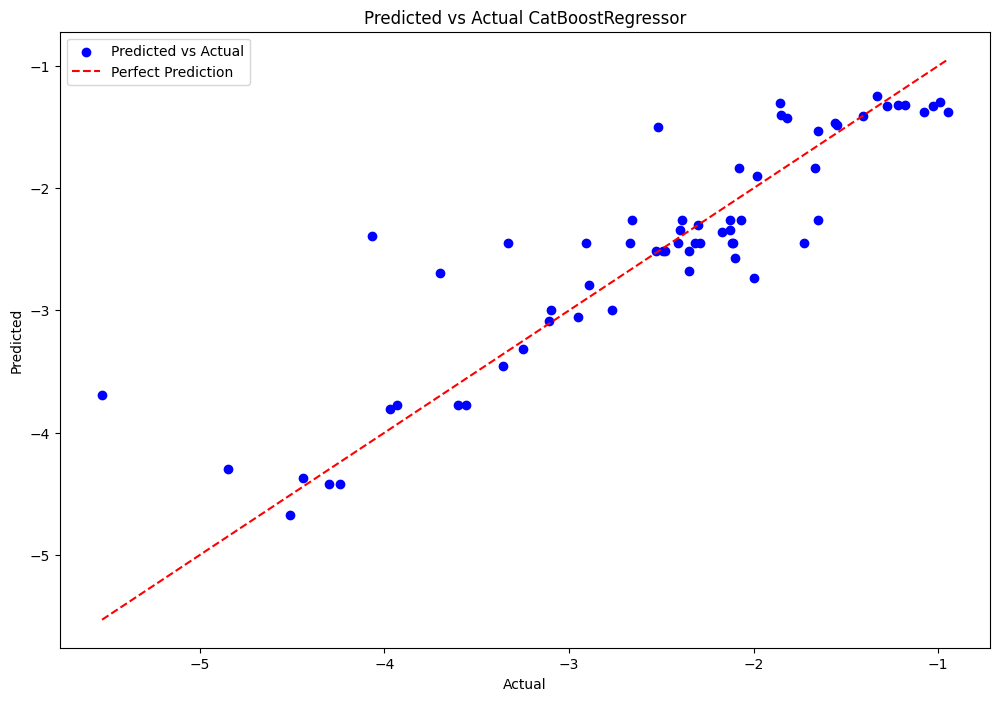

LGBMRegressor
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1968
[LightGBM] [Info] Number of data points in the train set: 354, number of used features: 75
[LightGBM] [Info] Start training from score -2.632260
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

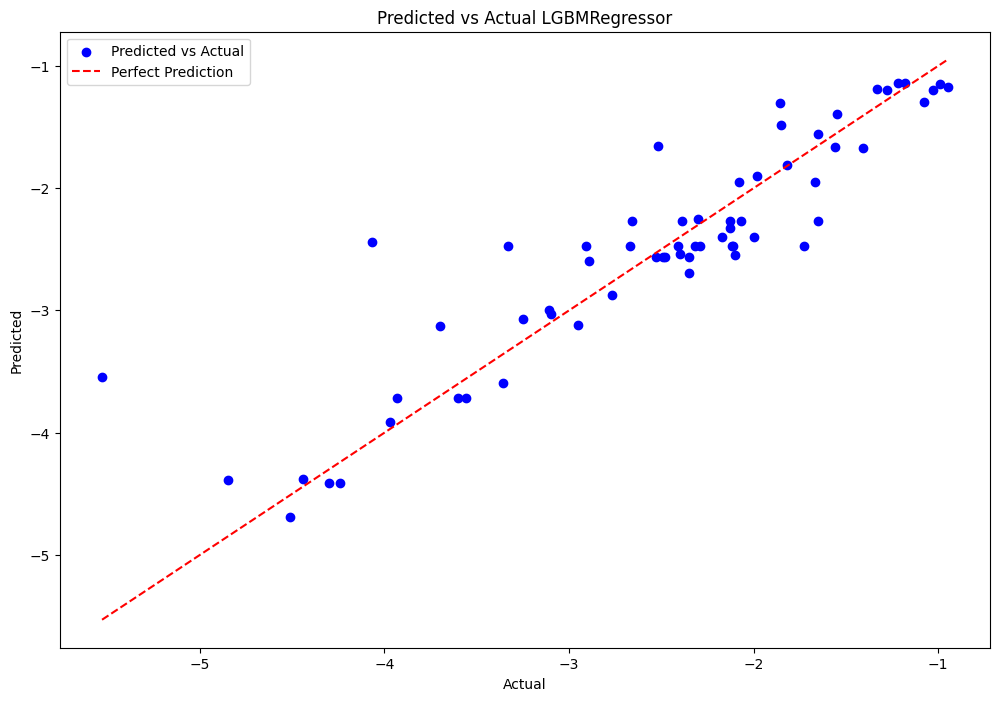

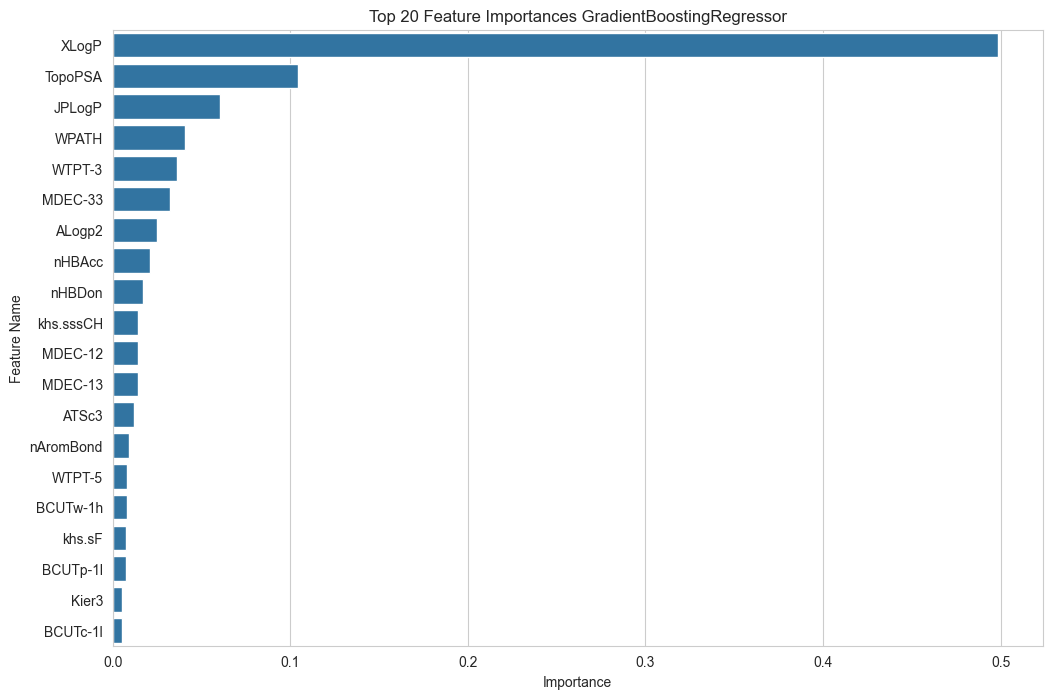

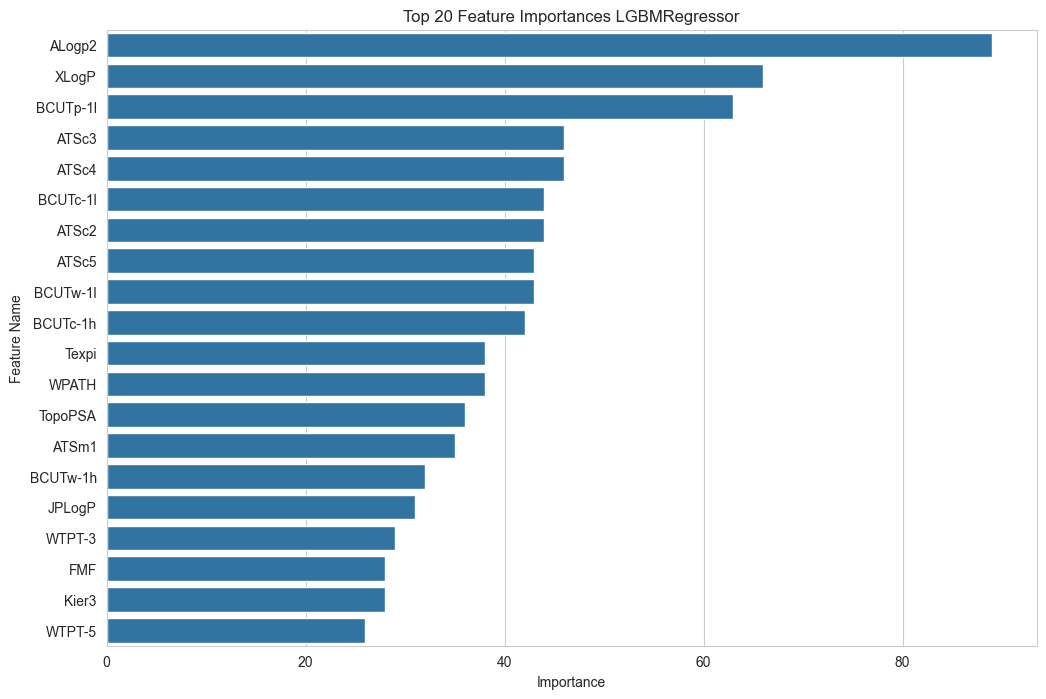

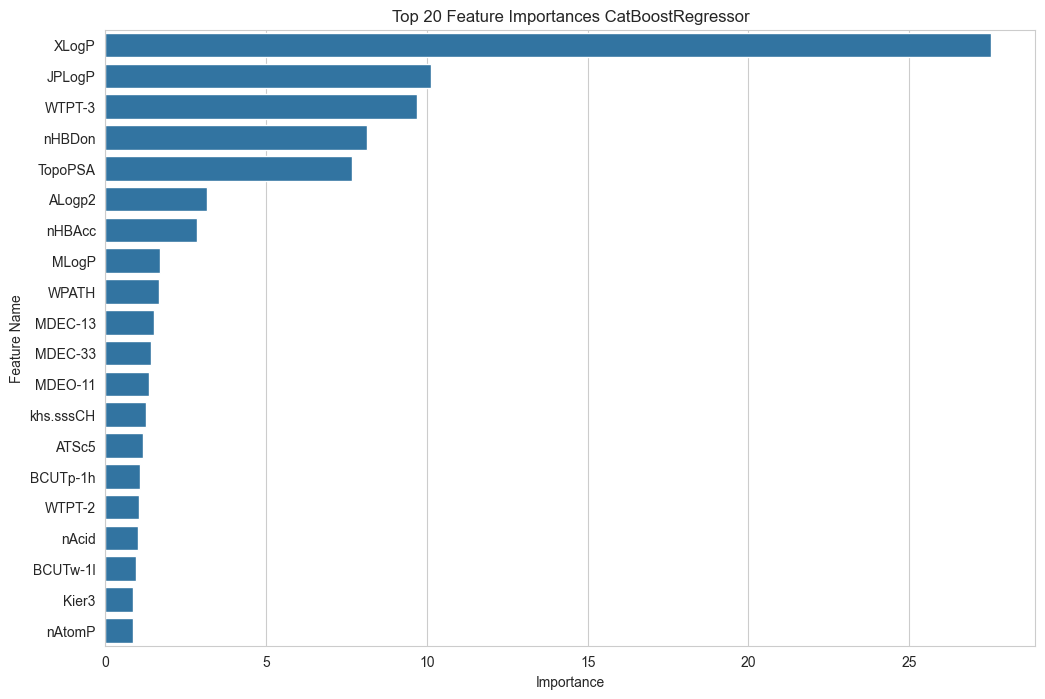

,model,Mean CV,MAE,MAPE,MSE,RMSE,R_Squared,Adjusted_R_Squared
0,LinearRegression,-9.673623e+11,1.302249e+08,3.519593e+07,1.068387e+18,1.033628e+09,-1.011357e+18,7.464775e+17
1,Lasso,-9.865381e-01,8.399749e-01,4.149462e-01,1.067373e+00,1.033138e+00,-1.039668e-02,1.745769e+00
2,DecisionTree,-4.797101e-01,3.353541e-01,1.414759e-01,2.962580e-01,5.442959e-01,7.195563e-01,1.206994e+00
3,RandomForest,-4.481261e-01,3.144802e-01,1.302760e-01,2.255215e-01,4.748911e-01,7.865169e-01,1.157571e+00
4,XGBRegressor,-4.500956e-01,3.029975e-01,1.232415e-01,2.280592e-01,4.775554e-01,7.841147e-01,1.159344e+00
5,GradientBoostingRegressor,-4.395407e-01,2.742682e-01,1.163274e-01,1.948399e-01,4.414068e-01,8.155607e-01,1.136134e+00
6,Elastic Net,-8.878485e-01,7.510306e-01,3.741900e-01,8.542022e-01,9.242306e-01,1.913953e-01,1.596827e+00
7,BayesianRidge,-5.256690e-01,3.645320e-01,1.663096e-01,2.733623e-01,5.228406e-01,7.412299e-01,1.190997e+00
8,CatBoostRegressor,-4.358443e-01,3.000598e-01,1.279687e-01,2.149384e-01,4.636145e-01,7.965351e-01,1.150176e+00
9,LGBMRegressor,-4.457704e-01,2.841501e-01,1.168810e-01,1.936219e-01,4.400248e-01,8.167137e-01,1.135283e+00


In [47]:
all_features, results_scores = train_and_evalute(X_train, X_test, y_train, y_test, metric="MAE")
all_features

In [ ]:
results_scores

,actual,Compound,SMILES,predictions_LGBMRegressor,predictions_RandomForest,predictions_CatBoostRegressor
0,-3.44,Methotrexate,CN(CC1=CN=C2C(=N1)C(=NC(=N2)N)N)C3=CC=C(C=C3)C...,-3.578073,-3.377851,-2.896919
1,-2.63,Estradiol,CC12CCC3C(C1CCC2O)CCC4=C3C=CC(=C4)O,-2.583965,-2.563901,-2.596668
2,-1.09,chloroxylenol,CC1=CC(=CC(=C1Cl)C)O,-1.244920,-1.300735,-1.338873
3,-0.78,7-Ethoxycoumarin,CCOC1=CC2=C(C=C1)C=CC(=O)O2,-0.987631,-1.180592,-1.164692
4,-1.27,Propylparaben,CCCOC(=O)C1=CC=C(C=C1)O,-1.656412,-1.669596,-1.588467
...,...,...,...,...,...,...
79,-1.95,testosterone,CC12CCC3C(C1CCC2O)CCC4=CC(=O)CCC34C,-2.311926,-2.315052,-2.317046
80,-0.74,"2,4-Dichloroacetophenone",C1=CC(=CC=C1C(=O)CCl)Cl,-1.819152,-1.679086,-1.468705
81,-1.51,Benzoic acid,C1=CC=C(C=C1)C(=O)O,-2.197229,-2.238283,-2.300404
82,-4.27,sucrose,C(C1C(C(C(C(O1)OC2(C(C(C(O2)CO)O)O)CO)O)O)O)O,-4.799342,-4.821761,-4.876010


<a id="ann"></a>
# 4. ANN


Epoch 1/2500

12/12 - 1s - loss: 3.0007 - val_loss: 2.4791 - 993ms/epoch - 83ms/step
Epoch 2/2500
12/12 - 0s - loss: 2.8332 - val_loss: 2.4306 - 42ms/epoch - 3ms/step
Epoch 3/2500
12/12 - 0s - loss: 2.6942 - val_loss: 2.4287 - 41ms/epoch - 3ms/step
Epoch 4/2500
12/12 - 0s - loss: 2.6468 - val_loss: 2.3861 - 42ms/epoch - 4ms/step
Epoch 5/2500
12/12 - 0s - loss: 2.6240 - val_loss: 2.3083 - 56ms/epoch - 5ms/step
Epoch 6/2500
12/12 - 0s - loss: 2.4388 - val_loss: 2.2762 - 44ms/epoch - 4ms/step
Epoch 7/2500
12/12 - 0s - loss: 2.5207 - val_loss: 2.2233 - 41ms/epoch - 3ms/step
Epoch 8/2500
12/12 - 0s - loss: 2.4317 - val_loss: 2.1769 - 40ms/epoch - 3ms/step
Epoch 9/2500
12/12 - 0s - loss: 2.3072 - val_loss: 2.1228 - 41ms/epoch - 3ms/step
Epoch 10/2500
12/12 - 0s - loss: 2.1027 - val_loss: 2.0619 - 40ms/epoch - 3ms/step
Epoch 11/2500
12/12 - 0s - loss: 2.0856 - val_loss: 2.0091 - 41ms/epoch - 3ms/step
Epoch 12/2500
12/12 - 0s - loss: 2.1914 - val_loss: 1.9261 - 40ms/epoch - 3ms/step
Epoch 13/

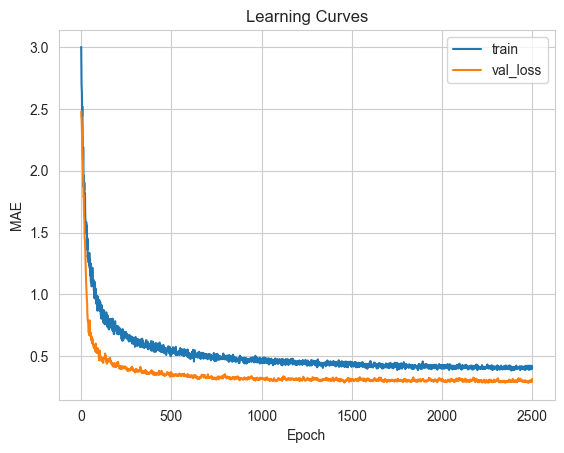

2/2 [==============================] - 0s 2ms/step
MAE: 0.3139661441152058
MSE: 0.21384342324223976
RMSE: 0.4624320741927832
MAPE: 0.12984311718073477
R2: 0.7975715907489589
2/2 [==============================] - 0s 2ms/step
Saved model to disk


,predicted,actual
0,-4.370386,-3.70
1,-2.301118,-2.17
2,-2.371734,-2.11
3,-3.595011,-3.25
4,-1.265762,-1.86
...,...,...
58,-2.386428,-2.30
59,-2.371734,-2.29
60,-2.222870,-2.13
61,-1.241509,-1.22


In [ ]:
final_result = ANN_model(X_train, X_test, y_train, y_test)
final_result

In [ ]:
results_scores['predictions_ANN'] = final_result['predicted']

In [ ]:
results_scores['mean'] = (results_scores['predictions_ANN'] + results_scores['predictions_CatBoostRegressor'] + results_scores['predictions_CatBoostRegressor'] + results_scores['predictions_XGBRegressor']) / 4

In [ ]:
results_scores

,actual,Compound,SMILES,predictions_XGBRegressor,predictions_CatBoostRegressor,predictions_LGBMRegressor,predictions_ANN,mean
0,-1.41,Benzylideneacetone,CC(=O)C=CC1=CC=CC=C1,-1.121665,-1.189869,-1.121698,-1.125018,-1.156605
1,-1.82,4-propoxyphenol,CCCOC1=CC=C(C=C1)O,-1.827566,-1.468094,-1.758048,-1.514402,-1.569539
2,-2.21,Corticosterone,CC12CCC(=O)C=C1CCC3C2C(CC4(C3CCC4C(=O)CO)C)O,-2.467710,-2.438703,-2.469578,-2.466597,-2.452929
3,-1.22,"2,4-Dichlorophenol",C1=CC(=C(C=C1Cl)Cl)O,-1.190483,-1.239560,-1.219402,-1.250912,-1.230129
4,-2.79,Alprenolol,CC(C)NCC(COC1=CC=CC=C1CC=C),-1.855024,-1.756029,-1.924435,-3.096743,-2.115956
...,...,...,...,...,...,...,...,...
79,-3.93,Urea,C(=O)(N)N,-3.767368,-3.764141,-3.763079,-3.770163,-3.766453
80,-3.97,Mannitol,C(C(C(C(C(CO)O)O)O)O)O,-4.368868,-4.293529,-4.368040,-4.586554,-4.385620
81,-2.01,testosterone,CC12CCC3C(C1CCC2O)CCC4=CC(=O)CCC34C,-2.190077,-2.169239,-2.207644,-2.364748,-2.223326
82,-1.13,o-t-butylphenol,CC(C)(C)C1=CC=CC=C1O,-1.279589,-1.665958,-1.548069,0.688029,-0.980869


In [ ]:
results_scores['diff'] = abs(results_scores['actual'] - results_scores['mean'])

In [ ]:
results_scores.to_excel("../../results/predictions.xlsx", index=False)

# 5. Hyperparameter Tuning

In [ ]:
np.random.seed(1)
# Define the regression models
models = {
    'RandomForest': RandomForestRegressor(),
    'DecisionTree': DecisionTreeRegressor(),
    'XGBoost': XGBRegressor(),
    'LightGBM': LGBMRegressor(),
    'CatBoost': CatBoostRegressor(allow_writing_files=False, verbose=0),
    'GradientBoosting': GradientBoostingRegressor()
}

# Define parameter grids for each model
param_grids = {
    'RandomForest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20],
                     'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
    'DecisionTree': {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10],
                     'min_samples_leaf': [1, 2, 4]},
    'XGBoost': {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7],
                'learning_rate': [0.01, 0.1, 0.2], 'subsample': [0.8, 1.0]},
    'LightGBM': {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7],
                 'learning_rate': [0.01, 0.1, 0.2], 'subsample': [0.8, 1.0]},
    'CatBoost': {'iterations': [50, 100, 200], 'depth': [3, 5, 7],
                 'learning_rate': [0.01, 0.1, 0.2], 'subsample': [0.8, 1.0]},
    'GradientBoosting': {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7],
                         'learning_rate': [0.01, 0.1, 0.2], 'subsample': [0.8, 1.0]}
}

# Perform grid search for each model
for model_name, model in models.items():
    param_grid = param_grids[model_name]
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Print best parameters and corresponding MAE
    print(f"{model_name}:")
    # print("Best Parameters:", grid_search.best_params_)
    # print("Best MAE:", -grid_search.best_score_)  # negate the score to get positive MAE
    # print("="*30)

    # Evaluate the model on the test set with the best parameters
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_pred)
    print("Test MAE:", test_mae)
    print("="*30)

RandomForest:
Test MAE: 0.32502104878901983
DecisionTree:
Test MAE: 0.3205439199248723
XGBoost:
Test MAE: 0.30086846268366263
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1968
[LightGBM] [Info] Number of data points in the train set: 354, number of used features: 75
[LightGBM] [Info] Start training from score -2.632260
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers import Adam
# Function to create the Keras model
def create_model(learning_rate=0.0001, dropout_rate=0.2):
    model = Sequential([
        Dense(256, input_shape=[X_train.shape[1]]),
        Dropout(dropout_rate),
        Dense(128),
        Dropout(dropout_rate),
        Dense(64),
        Dropout(dropout_rate),
        Dense(32),
        Dropout(dropout_rate),
        Dense(8),
        Dense(1)
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="mean_absolute_error")
    return model

# Create KerasRegressor
model = KerasRegressor(build_fn=create_model, epochs=2500, batch_size=32, verbose=0)

# Define the grid search parameters
param_grid = {
    'learning_rate': [0.0001, 0.001, 0.01],
    'dropout_rate': [0.2, 0.3, 0.4]
}

# Use KFold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=1)

# Create and fit the GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=kf)
grid_result = grid.fit(X_train, y_train)

# Print the results
print("Best Parameters: ", grid_result.best_params_)
print("Best MAE: ", -grid_result.best_score_)
print("Test MAE: ", -grid_result.score(X_test, y_test))

C:\Users\user\AppData\Local\Temp\ipykernel_14272\2042521271.py:26: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, epochs=2500, batch_size=32, verbose=0)


Best Parameters:  {'dropout_rate': 0.2, 'learning_rate': 0.001}
Best MAE:  0.5323736466324261
Test MAE:  0.33648849150491145
